# Horizontal scaling via spatial chunking system

## Overview 

This notebook is an exploration of a spatial chunking system that supports efficient processing of a 30m zarr dataset with a couple of risk variables. Similiar to the zarr-based approach described in ["A Serverless Approach to Building Planetary-Scale EO Datacubes"](https://earthmover.io/blog/serverless-datacube-pipeline), our system breaks down large 30m CONUS  dataset into manageable, independently processable chunks. This enables embarrassingly parallel processing of the dataset.

## Core concepts

For ease of use, this system defines an object that provides the following capabilities

- definition of a chunking scheme
- spatial indexing to rapidly identify chunks that intersect with regions of interest
- coordinate transformations between pixel space and geographic coordinates
- visualization functionality for chunk layouts

In [ ]:
%load_ext autoreload
%autoreload 2

from ocr.chunking_config import ChunkingConfig

config = ChunkingConfig()
config

<POLYGON ((2327640 221280, 2327640 3267390, -2362380 3267390, -2362380 22128...>

`ChunkingConfig` uses the `USFS-wildfire-risk-communities` dataset as a template to compute properties (e.g. CONUS bounds, `transform`, chunk information) that are used to convert between chunk IDs and spatial bounds.

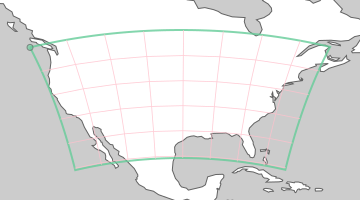

In [3]:
config.ds.odc.geobox

### Visualize all chunks

`.plot_all_chunks()` allows us to visualize the grid layout of our zarr/dask chunks and how they align with the CONUS geography. 

(-2362380.000000001, 2327639.999999999, 221280.00000000373, 3267390.0000000037)


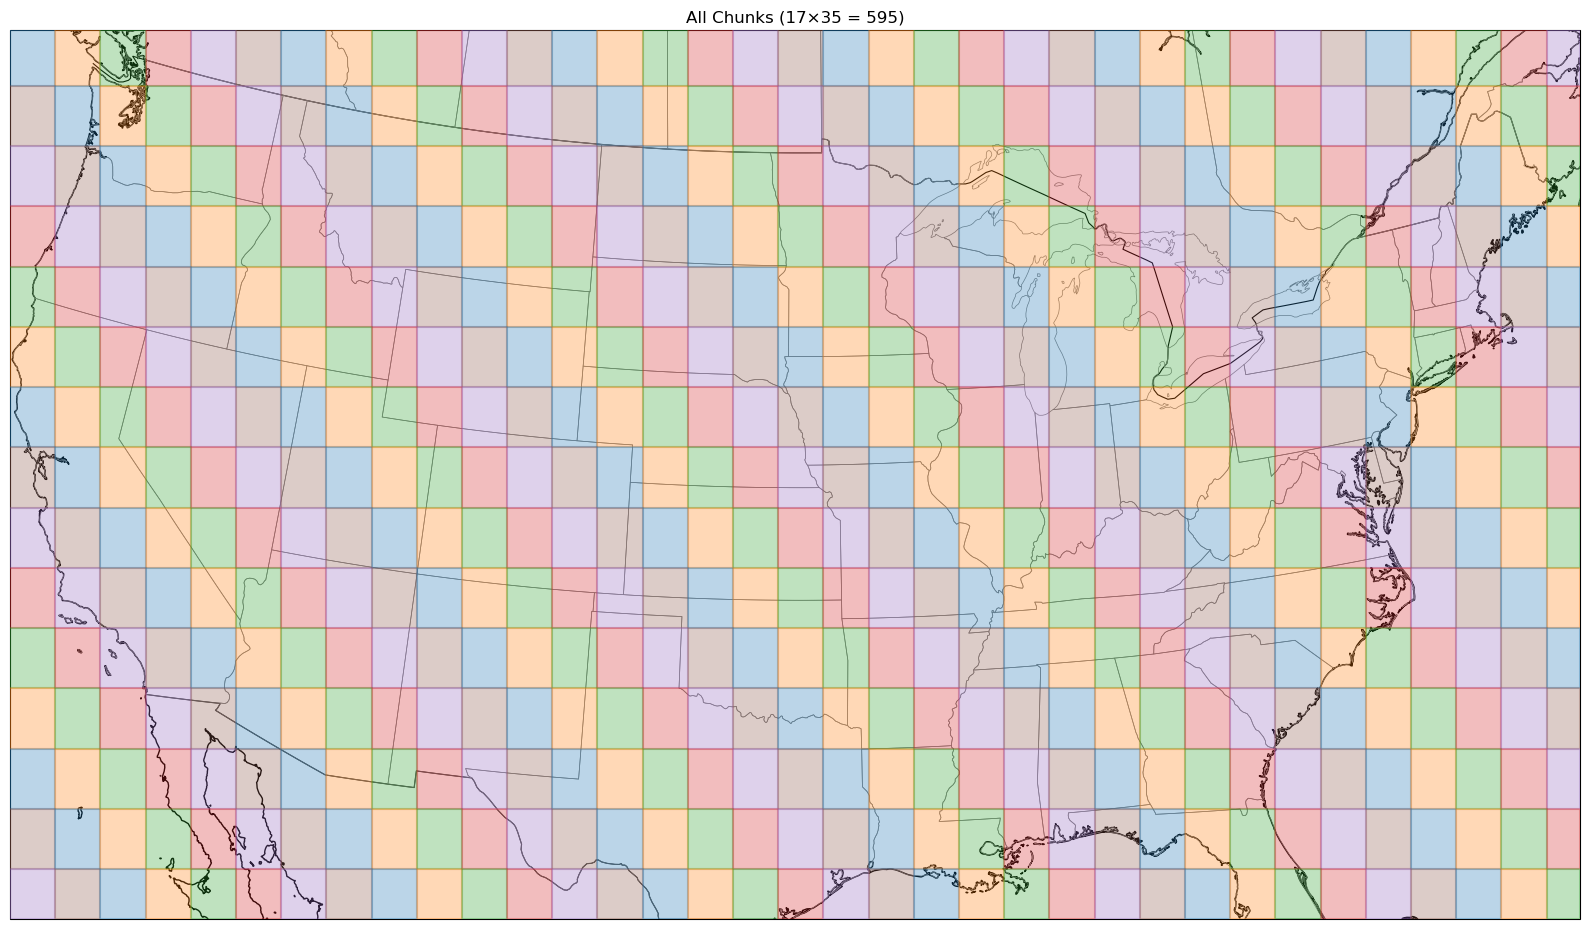

In [10]:
config.plot_all_chunks()

In the plot above, we can see the chunk layout of the `USFS-wildfire-risk-communities` dataset. The dataset has 595 chunks, each with size (6000, 4500). The chunks are arranged in a grid layout, with each chunk covering a specific geographic area.

In [6]:
config.ds

<xarray.Dataset> Size: 63GB
Dimensions:      (y: 101538, x: 156335)
Coordinates:
  * x            (x) float64 1MB -2.362e+06 -2.362e+06 ... 2.328e+06 2.328e+06
  * y            (y) float64 812kB 3.267e+06 3.267e+06 ... 2.213e+05 2.213e+05
    spatial_ref  int32 4B 5070
Data variables:
    CRPS         (y, x) float32 63GB dask.array<chunksize=(6000, 4500), meta=np.ndarray>

In [8]:
print(f'Number of dask/zarr chunks: {config.ds.CRPS.data.npartitions}')

Number of dask/zarr chunks: 595


In production, we would use this chunking system to process each chunk independently, allowing for parallel processing of the entire dataset. 

### Identify and process only the chunks that contain our regions of interest

In this section, we're demonstrating the spatial chunking capabilities

We've defined bounding boxes for three different regions:
- Colorado (co_bbox): A rectangular region covering the state of Colorado
- California (ca_bbox): A rectangular region covering the state of California 
- Arkansas (ar_bbox): A rectangular region covering the state of Arkansas


In [12]:
co_bbox = config.bbox_from_wgs84(-109.059196, 36.992751, -102.042126, 41.001982)
ca_bbox = config.bbox_from_wgs84(
    -124.41060660766607, 32.5342307609976, -114.13445790587905, 42.00965914828148
)
ar_bbox = config.bbox_from_wgs84(
    -94.61946646626465, 33.00413641175411, -89.65547287402873, 36.49965029279292
)

In [13]:
# Let's display the bounding boxes to see their coordinates
print('Colorado bbox:', co_bbox)
print('California bbox:', ca_bbox)
print('Arkansas bbox:', ar_bbox)

Colorado bbox: POLYGON ((-503825.24969709275 1566873.4386686818, -503825.24969709275 2073964.8986808355, -1147797.4769574092 2073964.8986808355, -1147797.4769574092 1566873.4386686818, -503825.24969709275 1566873.4386686818))
California bbox: POLYGON ((-1482611.4596796783 1212473.105868848, -1482611.4596796783 2458713.819631483, -2614643.551906299 2458713.819631483, -2614643.551906299 1212473.105868848, -1482611.4596796783 1212473.105868848))
Arkansas bbox: POLYGON ((588741.8714309803 1104686.938080162, 588741.8714309803 1513488.3987090176, 122518.57454225051 1513488.3987090176, 122518.57454225051 1104686.938080162, 588741.8714309803 1104686.938080162))



The next cell will:

1. Identify all chunks that intersect with each bounding box using get_chunks_for_bbox()
2. Visualize these chunks on the CONUS map to demonstrate how our chunking system
   can efficiently select only the data chunks needed for specific geographic regions

This illustrates a key advantage of the spatial chunking system; rather than
processing the entire CONUS dataset, we can quickly identify and process only
the chunks that contain our regions of interest. This comes in handy when debugging or re-running 
specific regions of interest, as we can avoid unnecessary processing of chunks that are not relevant. 

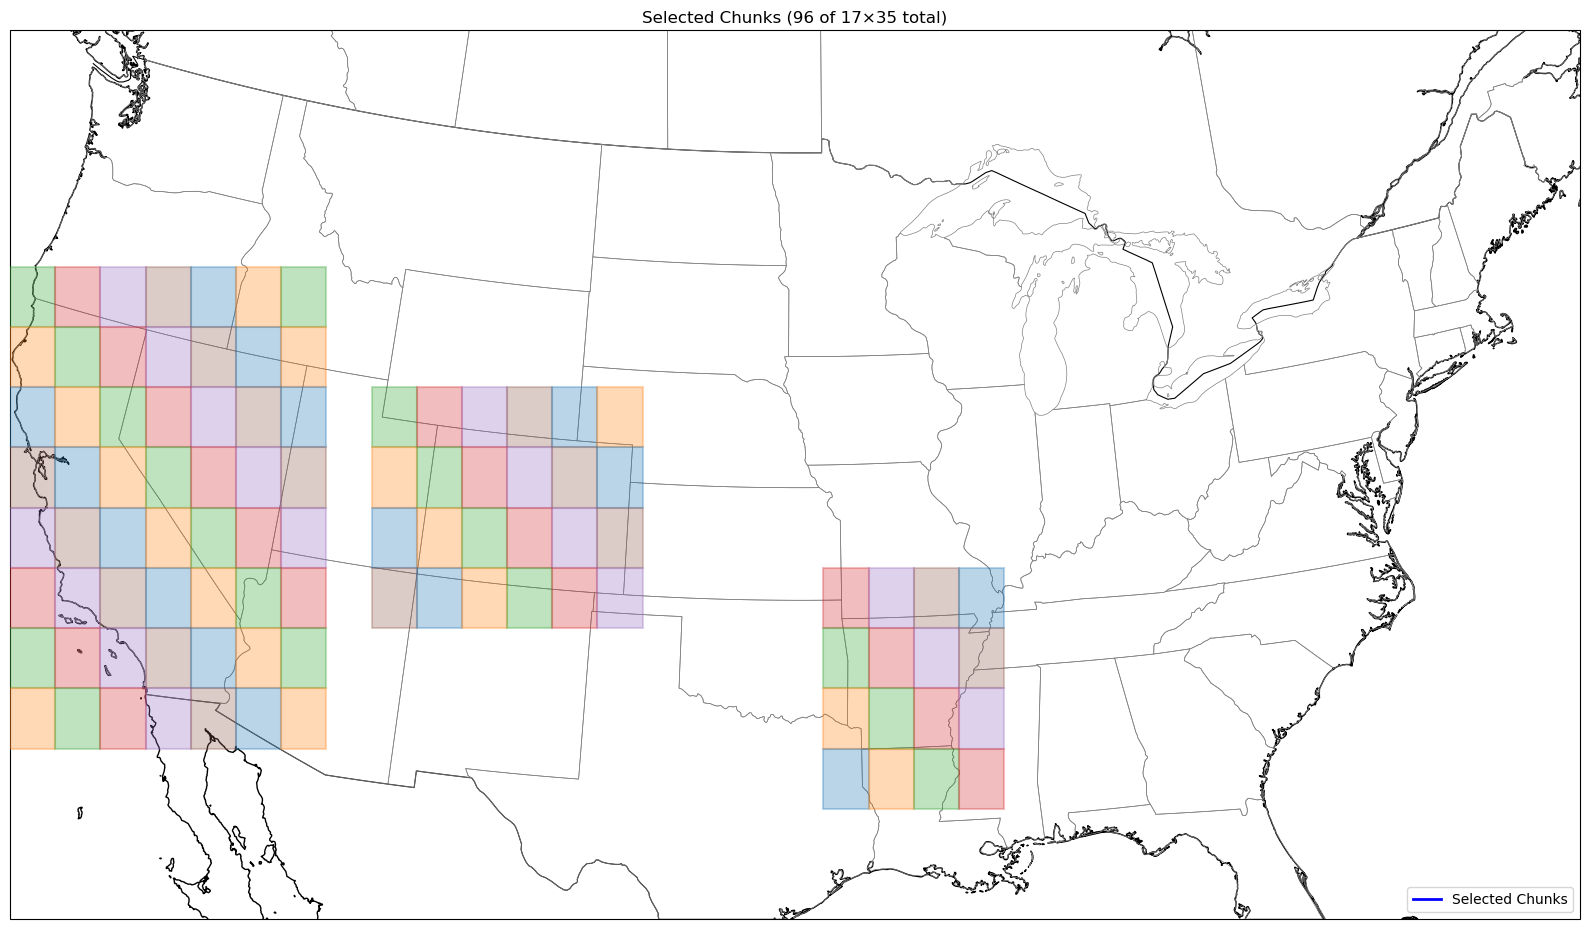

In [6]:
co_chunks = config.get_chunks_for_bbox(co_bbox)
ca_chunks = config.get_chunks_for_bbox(ca_bbox)
ar_chunks = config.get_chunks_for_bbox(ar_bbox)
config.visualize_chunks_on_conus(chunks=ca_chunks + co_chunks + ar_chunks)

In the cell below, we identify the chunks that intersect with the Eaton fire in California. 

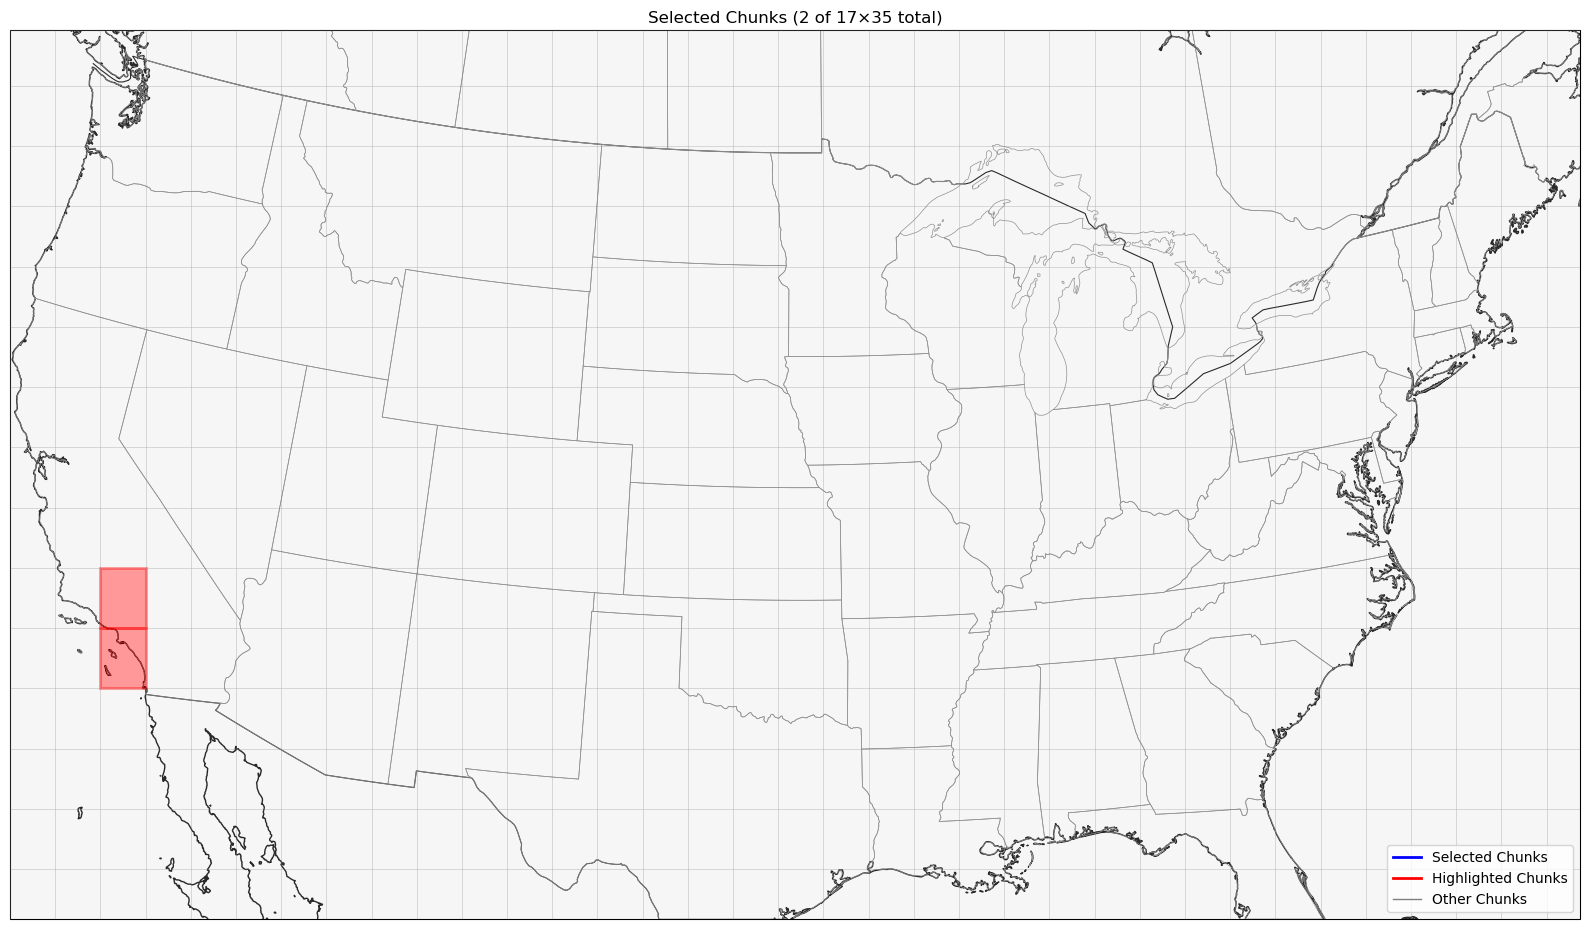

In [16]:
eaton_fire_bbox = config.bbox_from_wgs84(
    -118.16359507363843, 34.1609756217009, -118.01833468855428, 34.23216929604394
)
eaton_fire_chunks = config.get_chunks_for_bbox(eaton_fire_bbox)
config.visualize_chunks_on_conus(
    eaton_fire_chunks, highlight_chunks=eaton_fire_chunks, include_all_chunks=True
)

### Parallel processing framework

Like the serverless approach described in the blog post, our system enables embarrassingly parallel processing of chunks. 

This means that we can 

- create a template zarr store for the entire CONUS dataset
- process each chunk independently, and save the results using xarray's `to_zarr(region='auto')` method. Because our chunking system ensures that chunks are aligned with the CONUS geography, we can use the `region='auto'` argument to automatically determine the region for each chunk. 


Below is an example pseudo code for how this might look in practice:

```python

def process_chunks_for_geometry(
    run_config: ChunkingConfig,
    geometry: Polygon,
    process_func: Optional[Callable[[Tuple[int, int], xr.DataArray], Dict[str, Any]]] = None,
    max_workers: int = 8
):
    """Process all chunks intersecting with any arbitrary geometry in parallel"""
    # Find all chunks intersecting with geometry
    chunks = run_config.get_chunks_for_bbox(geometry.bounds)
    
    # Filter chunks to only those that actually intersect the geometry
    filtered_chunks = []
    for chunk_id in chunks:
        chunk_box = run_config.chunk_id_to_bounds(chunk_id)
        if geometry.intersects(chunk_box):
            filtered_chunks.append(chunk_id)
    
    # Process chunks in parallel
    with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
        future_to_chunk = {
            executor.submit(process_chunk, chunk_id): chunk_id 
            for chunk_id in filtered_chunks
        }
        
        # Collect results as they complete
        results = []
        for future in tqdm(concurrent.futures.as_completed(future_to_chunk), 
                         total=len(filtered_chunks),
                         desc="Processing chunks"):
            # Process results...
```

The `process_chunk` function would be defined to handle the actual processing of each chunk, including loading the input data, applying any transformations or calculations, and saving the results back to the zarr store.